# Embedded Syestem Assignment - Power Measurement of a UWB Embedded Platform


## Introduction
In this workbook I will explain a method to measure te power comsumption of an embedded system, in this example we used a Low-power board for Ultra Wide Band (UWB) based on DWM1001 module.

## Environment setup
To measure the power com

# Python execution

TODO:
 - [ ] Theory
 - [ ] Controlling lables
 - [ ] Managing multiple files

## **Before executing the notebook**
1. Upload the oscilloscope output files under lateral filesystem menù
2. Define under here the number of files you have uploaded or you want to take in consideration during calculus
> Note: the file names should be in `data-ok_<number of the file>.csv` format
3. Define the value of the $R_{sense}$ used for mesurement in $\Omega$




In [8]:
Vdd = 3.3
filesNumber = 7
Rsense = 1
# debug = False
debug = True
dbFileN = 2


# Define Channles Usage
if debug == False:
  functions = {
      'Vdd_CH':    'Channel C (V)',
      'Vsense_CH': 'Channel B (V)',
      'GPIO13_CH': 'Channel D (V)',
      'GPIO23_CH': 'Channel A (V)'
  }

else:
  if dbFileN == 1:
    functions = {
        'Vdd_CH':    'Channel A (V)',
        'Vsense_CH': 'Channel B (V)',
        'GPIO13_CH': 'Channel D (V)',
        'GPIO23_CH': 'Channel C (V)'
    }
  elif dbFileN == 2:
    functions = {
        'Vdd_CH':    'Channel A (V)',
        'Vsense_CH': 'Channel D (V)',
        'GPIO13_CH': 'Channel B (V)',
        'GPIO23_CH': 'Channel C (V)'
    }

# Find channel for function:
def get_channel(function_name):
    return functions.get(function_name)


## Importing libraries


In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import cumulative_trapezoid
import seaborn as sns
from matplotlib import pyplot as plt
import math

sns.set_style("whitegrid")
# sns.set(rc={'figure.figsize':(11,7)})

## Creating DataFrames


In [9]:
# # Read the first two lines (headers)
if debug == False:
  header = pd.read_csv("data/data-ok_1.csv", nrows=2)
  # Read the dataset
  df = pd.read_csv("data/data-ok_1.csv", skiprows=2)
else:
  # Read the first two lines (headers)
  header = pd.read_csv(f"data/data{dbFileN}.csv", nrows=2)
  # Read the dataset
  df = pd.read_csv(f"data/data{dbFileN}.csv", skiprows=2)

# Create new cols name by inserting de um into the name
new_columns = [
    f"{col} {unit}" for col, unit in zip(header.columns, header.iloc[0])
]

# Renaming dataset column names
df.columns = new_columns
df.info()

# Convert to float64 and drop NaN
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df[['Time (s)', 'Channel A (V)', 'Channel B (V)', 'Channel C (V)', 'Channel D (V)']]
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Time (s)       100003 non-null  float64
 1   Channel A (V)  100003 non-null  object 
 2   Channel B (V)  100003 non-null  float64
 3   Channel C (V)  100003 non-null  float64
 4   Channel D (V)  100003 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 99997 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time (s)       99997 non-null  float64
 1   Channel A (V)  99997 non-null  float64
 2   Channel B (V)  99997 non-null  float64
 3   Channel C (V)  99997 non-null  float64
 4   Channel D (V)  99997 non-null  float64
dtypes: float64(5)
memory usage: 4.6 MB


## Data Analisys

### Row plot

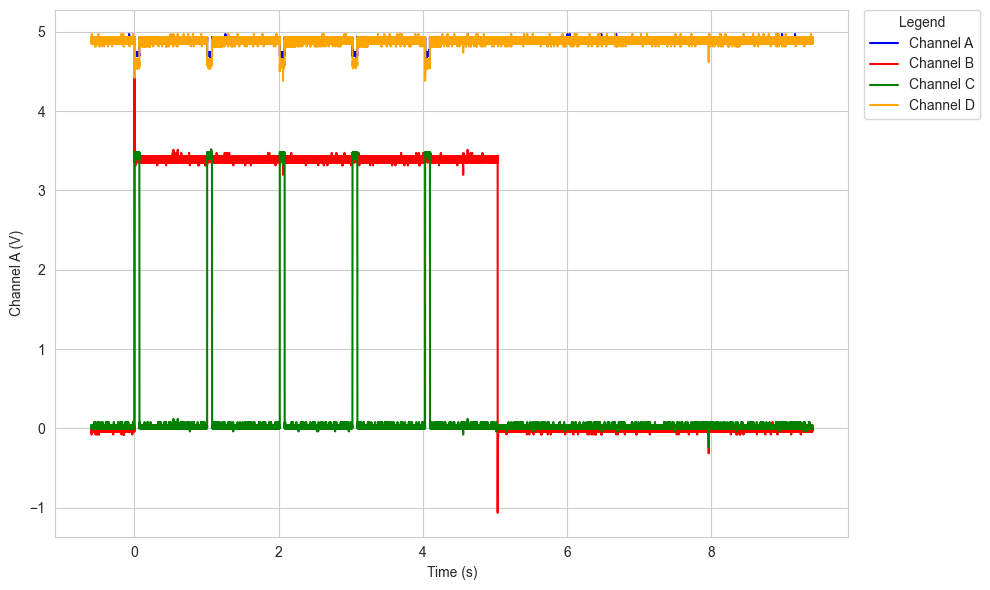

In [10]:
# Creating Axex and figure
fig, ax = plt.subplots(figsize=(10, 6))

# Row plot
sns.lineplot(data=df, x='Time (s)', y='Channel A (V)', ax= ax, label = "Channel A", color = 'blue')
sns.lineplot(data=df, x='Time (s)', y='Channel B (V)', ax= ax, label = "Channel B", color = 'red')
sns.lineplot(data=df, x='Time (s)', y='Channel C (V)', ax= ax, label = "Channel C", color = 'green')
sns.lineplot(data=df, x='Time (s)', y='Channel D (V)', ax= ax, label = "Channel D",color = 'orange')

# Set legend position in on right side (off of the chart)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0.)
plt.tight_layout()

# Plot
plt.show()


### Plot signal names

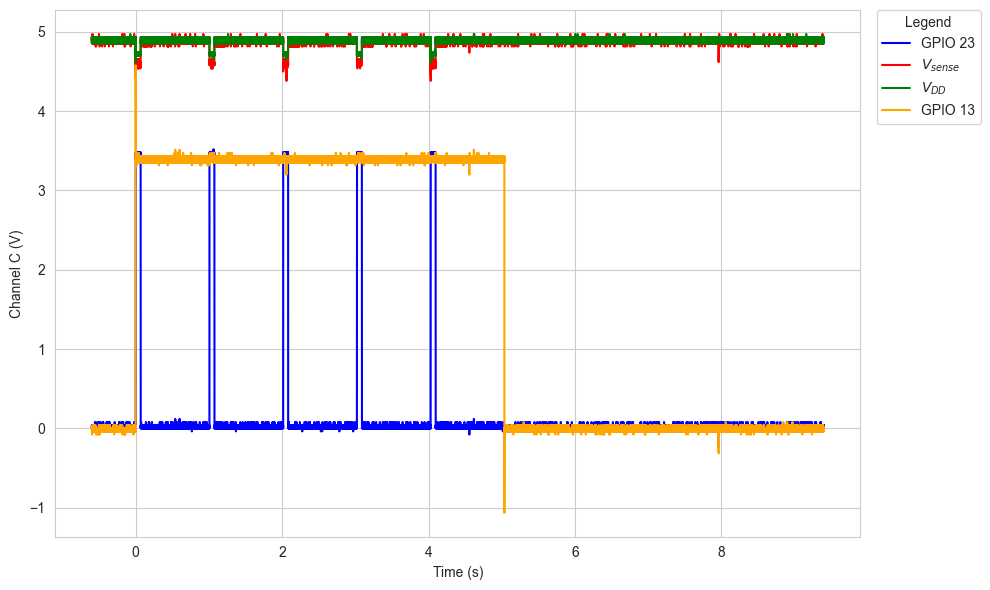

In [11]:
# Creating Axex and figure
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df, x='Time (s)', y=get_channel('GPIO23_CH'), ax= ax, label = "GPIO 23", color = 'blue')
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vsense_CH'), ax= ax, label = "$V_{sense}$", color = 'red')
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vdd_CH'), ax= ax, label = "$V_{DD}$", color = 'green')
sns.lineplot(data=df, x='Time (s)', y=get_channel('GPIO13_CH'), ax= ax, label = "GPIO 13",color = 'orange')

# Set legend position in on right side (off of the chart)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Legend', bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0.)
plt.tight_layout()

# Plot
plt.show()

### Calculating Current and Power

Mean Power: 13.344136463128995 mW
Std Power: 72.26394986545604 mW


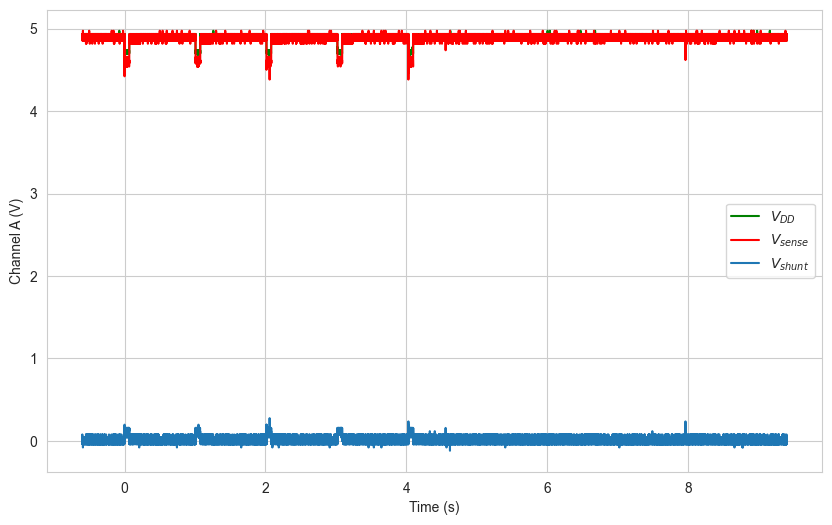

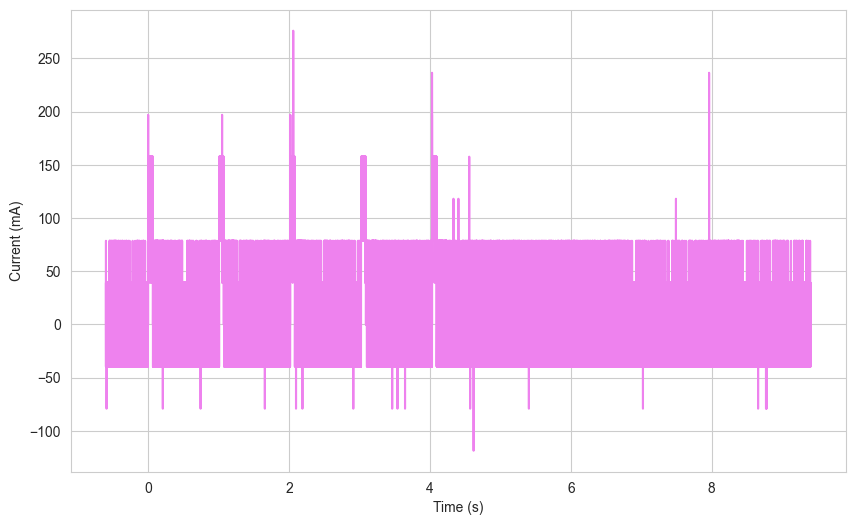

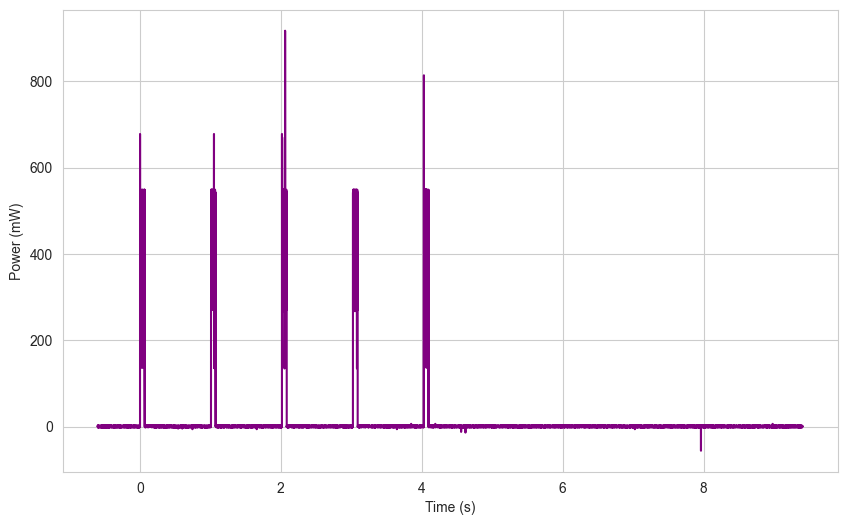

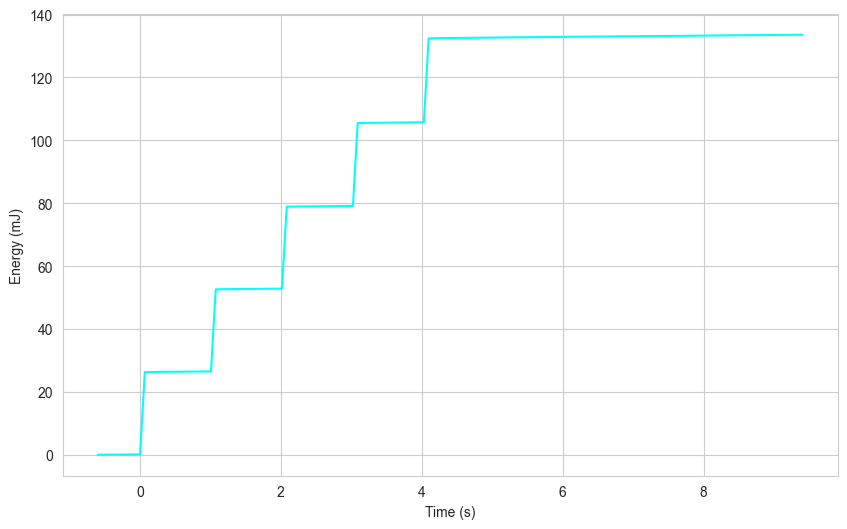

In [12]:
# Calculating the voltage drop over Rsense
df['Shunt Voltage (V)'] = df[get_channel('Vdd_CH')] - df[get_channel('Vsense_CH')]

# Calculating the current drowned by the system
df['Current (mA)'] = ((df[get_channel('Vdd_CH')] - df[get_channel('Vsense_CH')]) / Rsense ) * 1000

# Calculating the power consumption of the wole system (shunt included)
df['Power (mW)'] = df['Current (mA)'] * df['Channel C (V)']

# Calculating the energy
df["Energy (mJ)"] = cumulative_trapezoid(df["Power (mW)"], x=df["Time (s)"], initial=0)

# Calculating mean and std of the wole application
powerTaskMean = df['Power (mW)'].mean()
powerTaskStd = df['Power (mW)'].std()
print(f"Mean Power: {powerTaskMean} mW")
print(f"Std Power: {powerTaskStd} mW")

#Plot Voltages over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vdd_CH'), ax= ax, label = "$V_{DD}$", color = 'green')
sns.lineplot(data=df, x='Time (s)', y=get_channel('Vsense_CH'), ax= ax, label = "$V_{sense}$", color = 'red')
sns.lineplot(data=df, x='Time (s)', y='Shunt Voltage (V)', ax= ax, label = "$V_{shunt}$")
plt.show()

# Plot the current over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y='Current (mA)', ax=ax, color = 'violet')
plt.show()

# Plot the power over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y='Power (mW)', ax=ax, color = 'purple')
plt.show()

# Plot energy over time
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df, x='Time (s)', y='Energy (mJ)', ax=ax, color = 'cyan')
plt.show()


In [ ]:
# Defining a trunc function
def trunc(n):
  return int(n * 10000) / 10000.0

def getPhasesEnergy(df):
  """
    @brief    Find when in a Pandas DF are two rows whit more than one sample
    @retunrs  An array with the energy for each bloc of data
  """
  EnergyArr = []
  Chunks = 0
  ItemTime = (df.iloc[0, df.columns.get_loc('Time (s)')])
  Energy0 = df.iloc[0, df.columns.get_loc('Energy (mJ)')]
  for i in range(1, len(df)):
    timeDiff = (df.iloc[i, df.columns.get_loc('Time (s)')]) - ItemTime
    Energy = df.iloc[i - 1, df.columns.get_loc('Energy (mJ)')] - Energy0
    energyA = df.iloc[i, df.columns.get_loc('Energy (mJ)')]
    timeA = df.iloc[i, df.columns.get_loc('Time (s)')]
    if i == len(df) - 1:
      EnergyArr.append(df.iloc[i, df.columns.get_loc('Energy (mJ)')] - Energy0)
      Chunks += 1
    elif trunc(timeDiff) > 0.0001 and i != len(df):
      Chunks += 1
      EnergyArr.append(Energy)
      Energy0 = df.iloc[i, df.columns.get_loc('Energy (mJ)')]
      # print(f"Chunk: {Chunks}, index {i}, time was {ItemTime}, energy was {Energy}, Energy0: {Energy0}, energyA: {energyA}, timediff:{timeDiff}")
      # print(f"Index: {i}, timeDiff: {timeDiff}, TimeA: {timeA}, ItemTime: {ItemTime}, e:{timeDiff - 0.0001 }") 
    ItemTime = (df.iloc[i , df.columns.get_loc('Time (s)')])
  return EnergyArr, Chunks

#Transmit Mean Power
dfTx = df[(df[get_channel('GPIO13_CH')] > Vdd/2) & (df[get_channel('GPIO23_CH')] > Vdd/2) & (df['Time (s)'] < 6)]
powerTxMean = dfTx['Power (mW)'].mean()
powerTxStd = dfTx['Power (mW)'].std()

print(f"Mean TX Power: {powerTxMean} mW")
print(f"Std TX Power: {powerTxStd} mW")

#Idle Mean Power
dfIdle = df[(df[get_channel('GPIO13_CH')] < Vdd/2) & (df[get_channel('GPIO23_CH')] < Vdd/2) & (df['Time (s)'] > 1)]
powerIdleMean = dfIdle['Power (mW)'].mean()
powerIdleStd = dfIdle['Power (mW)'].std()

print(f"Mean Idle Power: {powerIdleMean} mW")
print(f"Std Idle Power: {powerIdleStd} mW")


# Calculate the derivative of GPIO signals
df['GPIO13_Diff'] = df[get_channel('GPIO13_CH')].diff() / df['Time (s)'].diff()
df['GPIO23_Diff'] = df[get_channel('GPIO23_CH')].diff() / df['Time (s)'].diff()

# Find rising and falling edges (when an edge occurs, the derivative is high (positive or negative))
risingEdges_GPIO13 = df[(df['GPIO13_Diff'] > 10000)]
risingEdges_GPIO23 = df[(df['GPIO23_Diff'] > 10000)]
fallingEdges_GPIO13 = df[(df['GPIO13_Diff'] < -10000)]
fallingEdges_GPIO23 = df[(df['GPIO23_Diff'] < -10000)]

# Calculate the integral beetween rising and falling edges for GPIO23 (Transmit Task)
if len(risingEdges_GPIO23) != len(fallingEdges_GPIO23):
  print("Warning: Number of rising and falling edges do not match!")
  print(f"Rising Edges: {len(risingEdges_GPIO23)}, Falling Edges: {len(fallingEdges_GPIO23)}")
  raise ValueError("Number of rising and falling edges do not match!")
else:
  txEnergyArr = []
  for i in range(len(risingEdges_GPIO23)):
    energy = fallingEdges_GPIO23.iloc[i]['Energy (mJ)'] - risingEdges_GPIO23.iloc[i]['Energy (mJ)']
    txEnergyArr.append(energy)
      
  # Calculate mean and std of the tx packets
  txEnergyMean = np.mean(txEnergyArr)
  txEnergyStd = np.std(txEnergyArr)  

print(f"Mean TX Energy: {txEnergyMean} mJ")
print(f"Std TX Energy: {txEnergyStd} mJ")

# Calculate the integral beetween the last falling edges of GPIO13 and the end (Idle Task)
if len(fallingEdges_GPIO13) > 0:
  i = len(fallingEdges_GPIO13) - 1
  last = len(df) - 1
  time = fallingEdges_GPIO13.iloc[i]['Time (s)']
  energy = df.iloc[last]["Energy (mJ)"] - fallingEdges_GPIO13.iloc[i]['Energy (mJ)']

print(f"Idle Energy: {energy} mJ")

#Calculate the integral beetween rising and falling edges for GPIO13 (Total Task)
if len(risingEdges_GPIO13) != len(fallingEdges_GPIO13):
  print("Warning: Number of rising and falling edges do not match!")
  print(f"Rising Edges: {len(risingEdges_GPIO13)}, Falling Edges: {len(fallingEdges_GPIO13)}")
  raise ValueError("Number of rising and falling edges do not match!")
else:
  totalEnergyArr = []
  for i in range(len(risingEdges_GPIO13)):
    energy = fallingEdges_GPIO13.iloc[i]['Energy (mJ)'] - risingEdges_GPIO13.iloc[i]['Energy (mJ)']
    totalEnergyArr.append(energy)
      
  # Calculate mean and std of the total task
  totalEnergyMean = np.mean(totalEnergyArr)
  totalEnergyStd = np.std(totalEnergyArr)
  # print(f"Mean Total Task Energy: {totalEnergyMean} mJ")
  # print(f"Std Total Task Energy: {totalEnergyStd} mJ")






Mean TX Power: 387.86076271307974 mW
Std TX Power: 95.74052870206216 mW
Mean Idle Power: 0.20564582267275394 mW
Std Idle Power: 0.8215599607297994 mW
Mean TX Energy: 26.26441824055363 mJ
Std TX Energy: 0.2255409964181132 mJ
Idle Energy: 0.8974636643550866 mJ
Mean Total Task Energy: 132.5971875783909 mJ
Std Total Task Energy: 0.0 mJ
